In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time
from matplotlib import colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib import cm, ticker
from matplotlib.colors import LinearSegmentedColormap


if 'path' in locals(): os.chdir(path)
else: os.chdir("../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/"
from pyMFI import MFI
from pyMFI import MFI1D
from pyMFI import run_plumed

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 22})
boldfont = {'fontname':'Helvetica', 'fontweight':'bold'}

plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

The path is: /Users/matteo/Projects/MFI_matteo/MFI


### Patch independent simulations and compute on the fly error

In [2]:
os.chdir(path + "/DATA_examples/colloidal_ML_CVs_data/") 
pbt_bandwidth = 0.035
n_simulations = 4
kT = 2
nbins=200

master = []
master_patch = [[np.zeros((nbins,nbins)), np.zeros((nbins,nbins)), np.zeros((nbins,nbins)), np.zeros((nbins,nbins)), np.zeros((nbins,nbins)), np.zeros((nbins,nbins))]]
ofe_history_patch = []
aad_history_patch = []
volume_history_patch = []
ofe_history_patch_time = []
OFE=np.zeros([n_simulations,nbins,nbins])

welltempered=np.array([0,1,1,1])
NHILLS=np.array([30000,22000,21000,22000])

for simulation in np.arange(0,n_simulations): 
    print('\nProcessing simulation '+str(simulation))
    #Read the HILLS and position file file
    HILLS=MFI.load_HILLS_2D(hills_name= str(simulation) + "/HILLS")
    [position_x, position_y] = MFI.load_position_2D(position_name= str(simulation) + "/colvar.out")

    #COMPUTE Mean force and weight of the simulation
    results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, 
                         WellTempered = welltempered[simulation],nhills=NHILLS[simulation],
                         bw = np.array((pbt_bandwidth, pbt_bandwidth)), kT = kT, 
                         min_grid=np.array((-1, -1)), max_grid=np.array((7.5, 7.5)),
                         nbins=np.array((nbins,nbins)), error_pace=100, 
                         base_terms = master_patch[-1], 
                         use_weighted_st_dev = False)
    
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
    
    
    ofe[cutoff==0]=np.NaN
    OFE[simulation,:,:]=ofe   
        
    #store results in master_array
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    #patch master and store result in master_patch
    master_patch.append(MFI.patch_2D(master))
    #save error history
    ofe_history_patch += ofe_history
    volume_history_patch += volume_history
    if len(ofe_history_patch_time) > 0: ofe_history_patch_time += [element+ofe_history_patch_time[-1] for element in time_history]
    else: ofe_history_patch_time += time_history

    
    
#integration on a non-periodic! domain
[Xp, Yp, FES_patch] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=np.array((-1, -1)), max_grid=np.array((7, 7)))


Processing simulation 0
|**************************************************| 100% | Average Mean Force Error: 16.325
Processing simulation 1
|**************************************************| 100% | Average Mean Force Error: 14.452
Processing simulation 2
|**************************************************| 100% | Average Mean Force Error: 14.607
Processing simulation 3
|**************************************************| 100% | Average Mean Force Error: 14.064

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


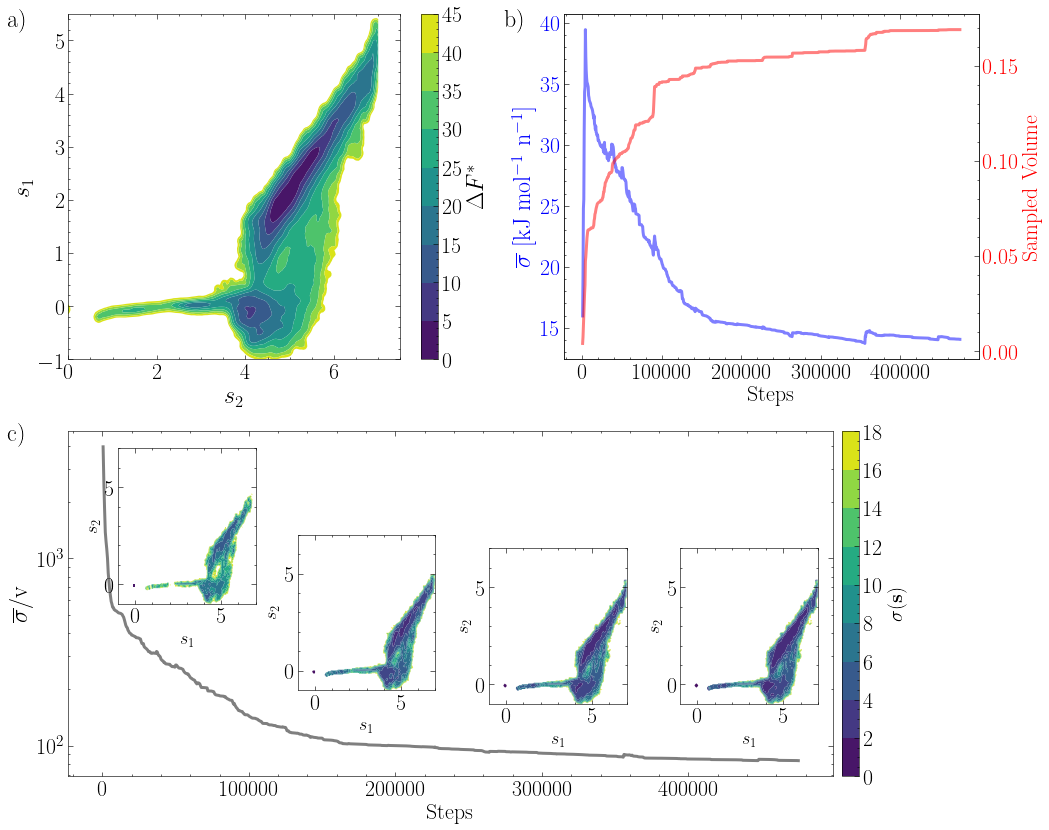

In [32]:
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)



# Plot
## Plot sub-figures setup
fig = plt.figure(figsize=(15, 12))
sub1 = fig.add_subplot(2,4,(1,2))
sub2 = fig.add_subplot(2,4,(3,4))
sub3 = fig.add_subplot(2,4,(5,8))
#sub4 = fig.add_subplot(3,4,9)
#sub5 = fig.add_subplot(3,4,10)
#sub6 = fig.add_subplot(3,4,11)
#sub7 = fig.add_subplot(3,4,12)


ax4 = plt.axes([1,1,1,1])
ip1 = InsetPosition(sub3, [0.065,0.5,0.18,0.45])
ax4.set_axes_locator(ip1)
ax4.set_xlabel('$s_1$',fontsize=18)
ax4.set_ylabel('$s_2$',fontsize=18)

ax5 = plt.axes([1,1,1,2])
ip2 = InsetPosition(sub3, [0.3,0.25,0.18,0.45])
ax5.set_axes_locator(ip2)
ax5.set_xlabel('$s_1$',fontsize=18)
ax5.set_ylabel('$s_2$',fontsize=18)

ax6 = plt.axes([1,1,1,3])
ip3 = InsetPosition(sub3, [0.55,0.21,0.18,0.45])
ax6.set_axes_locator(ip3)
ax6.set_xlabel('$s_1$',fontsize=18)
ax6.set_ylabel('$s_2$',fontsize=18)

ax7 = plt.axes([1,1,1,4])
ip4 = InsetPosition(sub3, [0.8,0.21,0.18,0.45 ])
ax7.set_axes_locator(ip4)
ax7.set_xlabel('$s_1$',fontsize=18)
ax7.set_ylabel('$s_2$',fontsize=18)




cp = sub1.contourf(Xp, Yp, FES_patch,levels=np.arange(0, 50, 5),cmap='viridis', antialiased=True, alpha=1);
cbar = plt.colorbar(cp, ax=sub1)
cbar.set_label("$\Delta F^*$",fontsize=24)
sub1.set_ylabel('$s_1$',fontsize=24)
sub1.set_xlabel('$s_2$',fontsize=24)
sub1.set_xlim(0,np.max(X))
sub1.set_ylim(np.min(Y),5.5)

sub2.plot(ofe_history_patch_time,ofe_history_patch,color='blue',alpha=0.5,linewidth=3,label="$\overline{\sigma}$");
sub2.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$ n$^{-1}$]',fontsize=24, color='blue')
sub2.tick_params(axis ='y', labelcolor = 'blue')
sub2.set_xlabel('Steps')

ax2 = sub2.twinx()
ax2.set_ylabel('Sampled Volume',color='red')
ax2.tick_params(axis ='y', labelcolor = 'red')
ax2.plot(ofe_history_patch_time,volume_history_patch,color='red',alpha=0.5,linewidth=3,label="$volume$");


convergence=np.divide(ofe_history_patch,volume_history_patch)

sub3.plot(ofe_history_patch_time,convergence,color='black',alpha=0.5,linewidth=3,label="$\overline{\sigma}$");
sub3.set_ylabel('$\overline{\sigma}$/v',fontsize=24, color='black')
sub3.tick_params(axis ='y', labelcolor = 'black')
sub3.set_xlabel('Steps')

sub3.set_yscale('log')
fig.tight_layout()    


#OFE[cutoff==0]=np.NaN
cp = ax4.contourf(Xp,Yp,OFE[0,:,:], levels=np.arange(0, 20, 2) ,cmap='viridis', antialiased=True, alpha=1);
cbar = plt.colorbar(cp, ax=sub3, shrink=1, pad=0.01)
cbar.set_label("$\sigma (\mathbf{s})$",fontsize=20)
cp = ax5.contourf(Xp,Yp,OFE[1,:,:], levels=np.arange(0, 25, 2) ,cmap='viridis', antialiased=True, alpha=1);
cp = ax6.contourf(Xp,Yp,OFE[2,:,:], levels=np.arange(0, 25, 2) ,cmap='viridis', antialiased=True, alpha=1);
cp = ax7.contourf(Xp,Yp,OFE[3,:,:], levels=np.arange(0, 25, 2) ,cmap='viridis', antialiased=True, alpha=1);


fig.text(0.02, 0.95, "a)",fontsize=24)
fig.text(0.48, 0.95, "b)",fontsize=24)
fig.text(0.02, 0.47, "c)",fontsize=24)

plt.savefig('Figure5', dpi=600, bbox_inches='tight')

